# Data Processing and Feature Engineering

## 1.Data Cleaning

### Loading data set using Pandas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
stores=pd.read_csv('stores.csv')
oil=pd.read_csv('oil.csv')
holidays_events=pd.read_csv('holidays_events.csv')

print(train.head())
print(test.head())

   id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0
        id        date  store_nbr      family  onpromotion
0  3000888  2017-08-16          1  AUTOMOTIVE            0
1  3000889  2017-08-16          1   BABY CARE            0
2  3000890  2017-08-16          1      BEAUTY            2
3  3000891  2017-08-16          1   BEVERAGES           20
4  3000892  2017-08-16          1       BOOKS            0


In [2]:
train.isna().sum()   # No Missing Value

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [3]:
test.isnull().sum()  # No Missing Value

id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64

In [4]:
stores.isna().sum()  # No Missing Value

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [5]:
holidays_events.isna().sum() # No Missing Value

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [6]:
oil.isna().sum()

date           0
dcoilwtico    43
dtype: int64

In [7]:
# Handling Missing Values using Interpolation
oil['dcoilwtico']=oil['dcoilwtico'].interpolate()

In [8]:
# Converting date columns to proper datetime formats

train['date']=pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])
oil['date'] = pd.to_datetime(oil['date'])
holidays_events['date'] = pd.to_datetime(holidays_events['date'])

In [9]:
# Merging data from stores,oil,holidays_events into the main dataset

df_train=train.merge(stores,on='store_nbr',how='left')
df_train=df_train.merge(oil,on='date',how='left')
df_train=df_train.merge(holidays_events,on='date',how='left')

df_test = test.merge(stores, on='store_nbr', how='left')
df_test = df_test.merge(oil, on='date', how='left')
df_test = df_test.merge(holidays_events, on='date', how='left')

In [10]:
df_train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,dcoilwtico,type_y,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False


In [11]:
df_train.onpromotion.unique().sum()

82566

## 2.Feature Engineering

In [13]:
# Extracting Time based Features

df_train['day']=df_train['date'].dt.day
df_train['month']=df_train['date'].dt.month
df_train['year']=df_train['date'].dt.year
df_train['day_of_week']=df_train['date'].dt.dayofweek

df_test['day'] = df_test['date'].dt.day
df_test['month'] = df_test['date'].dt.month
df_test['year'] = df_test['date'].dt.year
df_test['day_of_week'] = df_test['date'].dt.dayofweek

In [14]:
# Creating binary flags for holidays

df_train['is_holiday']=df_train['type_y'].notna().astype(int)
df_train['is_weekend']=(df_train['day_of_week'] >=5).astype(int)

df_test['is_holiday']=df_test['type_y'].notna().astype(int)
df_test['is_weekend']=(df_test['day_of_week'] >=5).astype(int)

In [15]:
#df_train.head()

In [16]:
# Identify if sales are higher in December (holiday season)
df_train['is_december'] = (df_train['month'] == 12).astype(int)
df_train['is_november'] = (df_train['month'] == 11).astype(int)  # Black Friday Effects
df_train['is_january'] = (df_train['month'] == 1).astype(int)  # Post-holiday drop

# Quarterly seasonality (Q1, Q2, Q3, Q4)
df_train['quarter'] = df_train['date'].dt.quarter

# Store-specific seasonal sales trend (Avg sales per month)
df_train['monthly_avg_sales'] = df_train.groupby(['store_nbr', 'family', 'month'])['sales'].transform('mean')

# Rolling Window for Seasonal Trends
df_train['rolling_mean_30'] = df_train.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: x.rolling(30, min_periods=1).mean())

# Display a preview
print(df_train[['date', 'sales', 'month', 'is_december', 'is_november', 'is_january', 'quarter', 'monthly_avg_sales']].head())

# Identify if sales are higher in December (holiday season)
df_test['is_december'] = (df_test['month'] == 12).astype(int)
df_test['is_november'] = (df_test['month'] == 11).astype(int)  # Black Friday Effects
df_test['is_january'] = (df_test['month'] == 1).astype(int)  # Post-holiday drop

# Quarterly seasonality (Q1, Q2, Q3, Q4)
df_test['quarter'] = df_test['date'].dt.quarter

# Display a preview
#print(df_test[['date', 'month', 'is_december', 'is_november', 'is_january', 'quarter']].head())

        date  sales  month  is_december  is_november  is_january  quarter  \
0 2013-01-01    0.0      1            0            0           1        1   
1 2013-01-01    0.0      1            0            0           1        1   
2 2013-01-01    0.0      1            0            0           1        1   
3 2013-01-01    0.0      1            0            0           1        1   
4 2013-01-01    0.0      1            0            0           1        1   

   monthly_avg_sales  
0           3.141935  
1           0.000000  
2           2.129032  
3        1615.354839  
4           0.167742  


In [17]:
#How This Captures Seasonal Trends?
#Monthly Sales Trends: Adds is_december, is_november, and is_january to identify holiday effects.
#
#Quarterly Seasonality: Adds quarter to capture trends across business quarters.
#
#Monthly Averages: Computes average sales per month for each store-product combination.
#
#Rolling Window (30 days): Helps smooth short-term fluctuations in sales.

In [19]:
# Creating binary flags for payday

df_train['is_payday']=df_train['day'].isin([15] + df_train['date'].dt.days_in_month.tolist()).astype(int)

df_test['is_payday']=df_test['day'].isin([15] + df_test['date'].dt.days_in_month.tolist()).astype(int)

In [20]:
# Adding Earthquake Impact feature

df_train['is_earthquake']=(df_train['date'] == '2016-04-16').astype(int)

df_test['is_earthquake']=(df_test['date'] == '2016-04-16').astype(int)

In [21]:
# Rolling Statistics

df_train['lag_7']=df_train.groupby(['store_nbr','family'])['sales'].shift(7)
df_train['lag_30']=df_train.groupby(['store_nbr','family'])['sales'].shift(30)

df_train['rolling_mean_7']=df_train.groupby(['store_nbr','family'])['sales'].transform(lambda x:x.rolling(7).mean())
df_train['rolling_std_7']=df_train.groupby(['store_nbr','family'])['sales'].transform(lambda x:x.rolling(7).std())

In [22]:
# Compute average sales per store type
store_type_sales = df_train.groupby('type_x')['sales'].mean().reset_index()
print("Average Sales per Store Type:")
store_type_sales['sales'] = store_type_sales['sales'].apply(lambda x: '{:,.2f}'.format(x))
print(store_type_sales)

Average Sales per Store Type:
  type_x   sales
0      A  708.38
1      B  328.28
2      C  197.79
3      D  352.08
4      E  270.29


In [23]:
# Identify top-selling product families per cluster
top_products_per_cluster = df_train.groupby(['cluster', 'family'])['sales'].sum().reset_index()
top_products_per_cluster = top_products_per_cluster.sort_values(['cluster', 'sales'], ascending=[True, False])
top_products_per_cluster = top_products_per_cluster.groupby('cluster').head(3)
print("Top Selling Product Families per Cluster:")
top_products_per_cluster['sales'] = top_products_per_cluster['sales'].apply(lambda x: '{:,.2f}'.format(x))
print(top_products_per_cluster)

Top Selling Product Families per Cluster:
     cluster     family          sales
12         1  GROCERY I  14,832,839.00
3          1  BEVERAGES  12,012,521.00
30         1    PRODUCE   8,221,405.85
45         2  GROCERY I   8,649,030.17
36         2  BEVERAGES   5,503,139.00
63         2    PRODUCE   5,068,958.65
78         3  GROCERY I  29,786,103.67
69         3  BEVERAGES  14,959,384.00
73         3   CLEANING  10,103,208.00
111        4  GROCERY I  16,825,191.92
102        4  BEVERAGES   8,343,193.00
129        4    PRODUCE   6,143,159.74
144        5  GROCERY I  16,715,953.82
135        5  BEVERAGES  13,696,172.00
162        5    PRODUCE  10,896,401.52
177        6  GROCERY I  43,971,769.79
168        6  BEVERAGES  23,628,801.00
172        6   CLEANING  12,271,643.00
210        7  GROCERY I   6,163,853.26
201        7  BEVERAGES   2,536,783.00
205        7   CLEANING   2,295,478.00
243        8  GROCERY I  27,684,913.96
234        8  BEVERAGES  23,763,744.00
261        8    PRODUC

### Exploratory Data Analysis

In [73]:
def plot_stats(df, column, ax, color, angle):
    count_classes = df[column].value_counts()
    ax = sns.barplot(x=count_classes.index, y=count_classes, ax=ax, palette=color)
    ax.set_title(column.upper(), fontsize=18)
    for tick in ax.get_xticklabels():
        tick.set_rotation(angle)

C:\Users\Sharjeel\AppData\Local\Temp\ipykernel_9700\472262147.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=count_classes.index, y=count_classes, ax=ax, palette=color)
C:\Users\Sharjeel\AppData\Local\Temp\ipykernel_9700\472262147.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=count_classes.index, y=count_classes, ax=ax, palette=color)


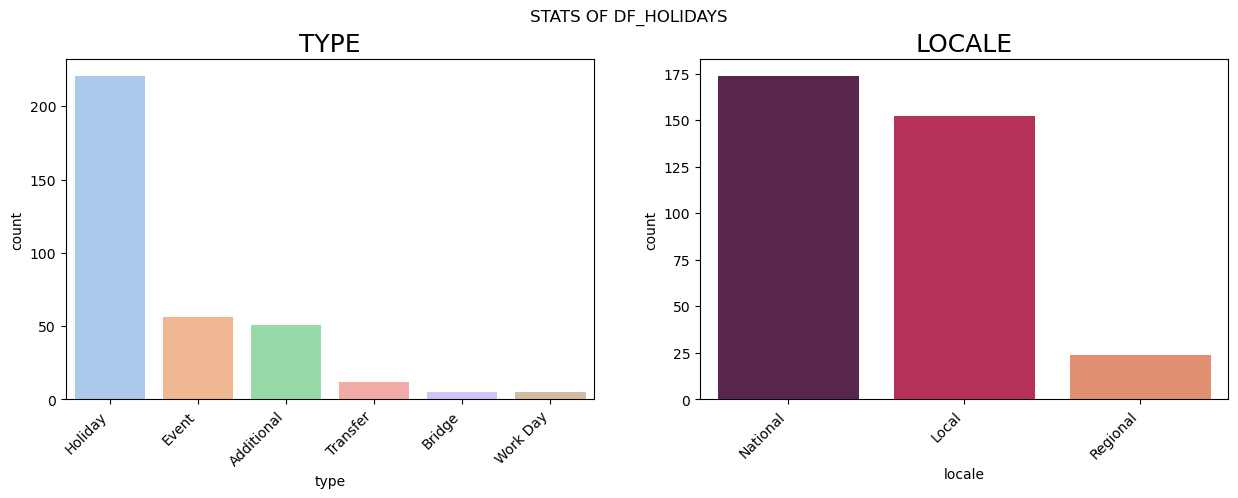

In [77]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
fig.autofmt_xdate()
fig.suptitle("Stats of df_holidays".upper())
plot_stats(holidays_events, "type", axes[0], "pastel", 45)
plot_stats(holidays_events, "locale", axes[1], "rocket", 45)
plt.show();

C:\Users\Sharjeel\AppData\Local\Temp\ipykernel_9700\472262147.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=count_classes.index, y=count_classes, ax=ax, palette=color)
C:\Users\Sharjeel\AppData\Local\Temp\ipykernel_9700\472262147.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=count_classes.index, y=count_classes, ax=ax, palette=color)
C:\Users\Sharjeel\AppData\Local\Temp\ipykernel_9700\472262147.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=count_classes.index, y=count_classes, ax=ax, palette=color)
C:\U

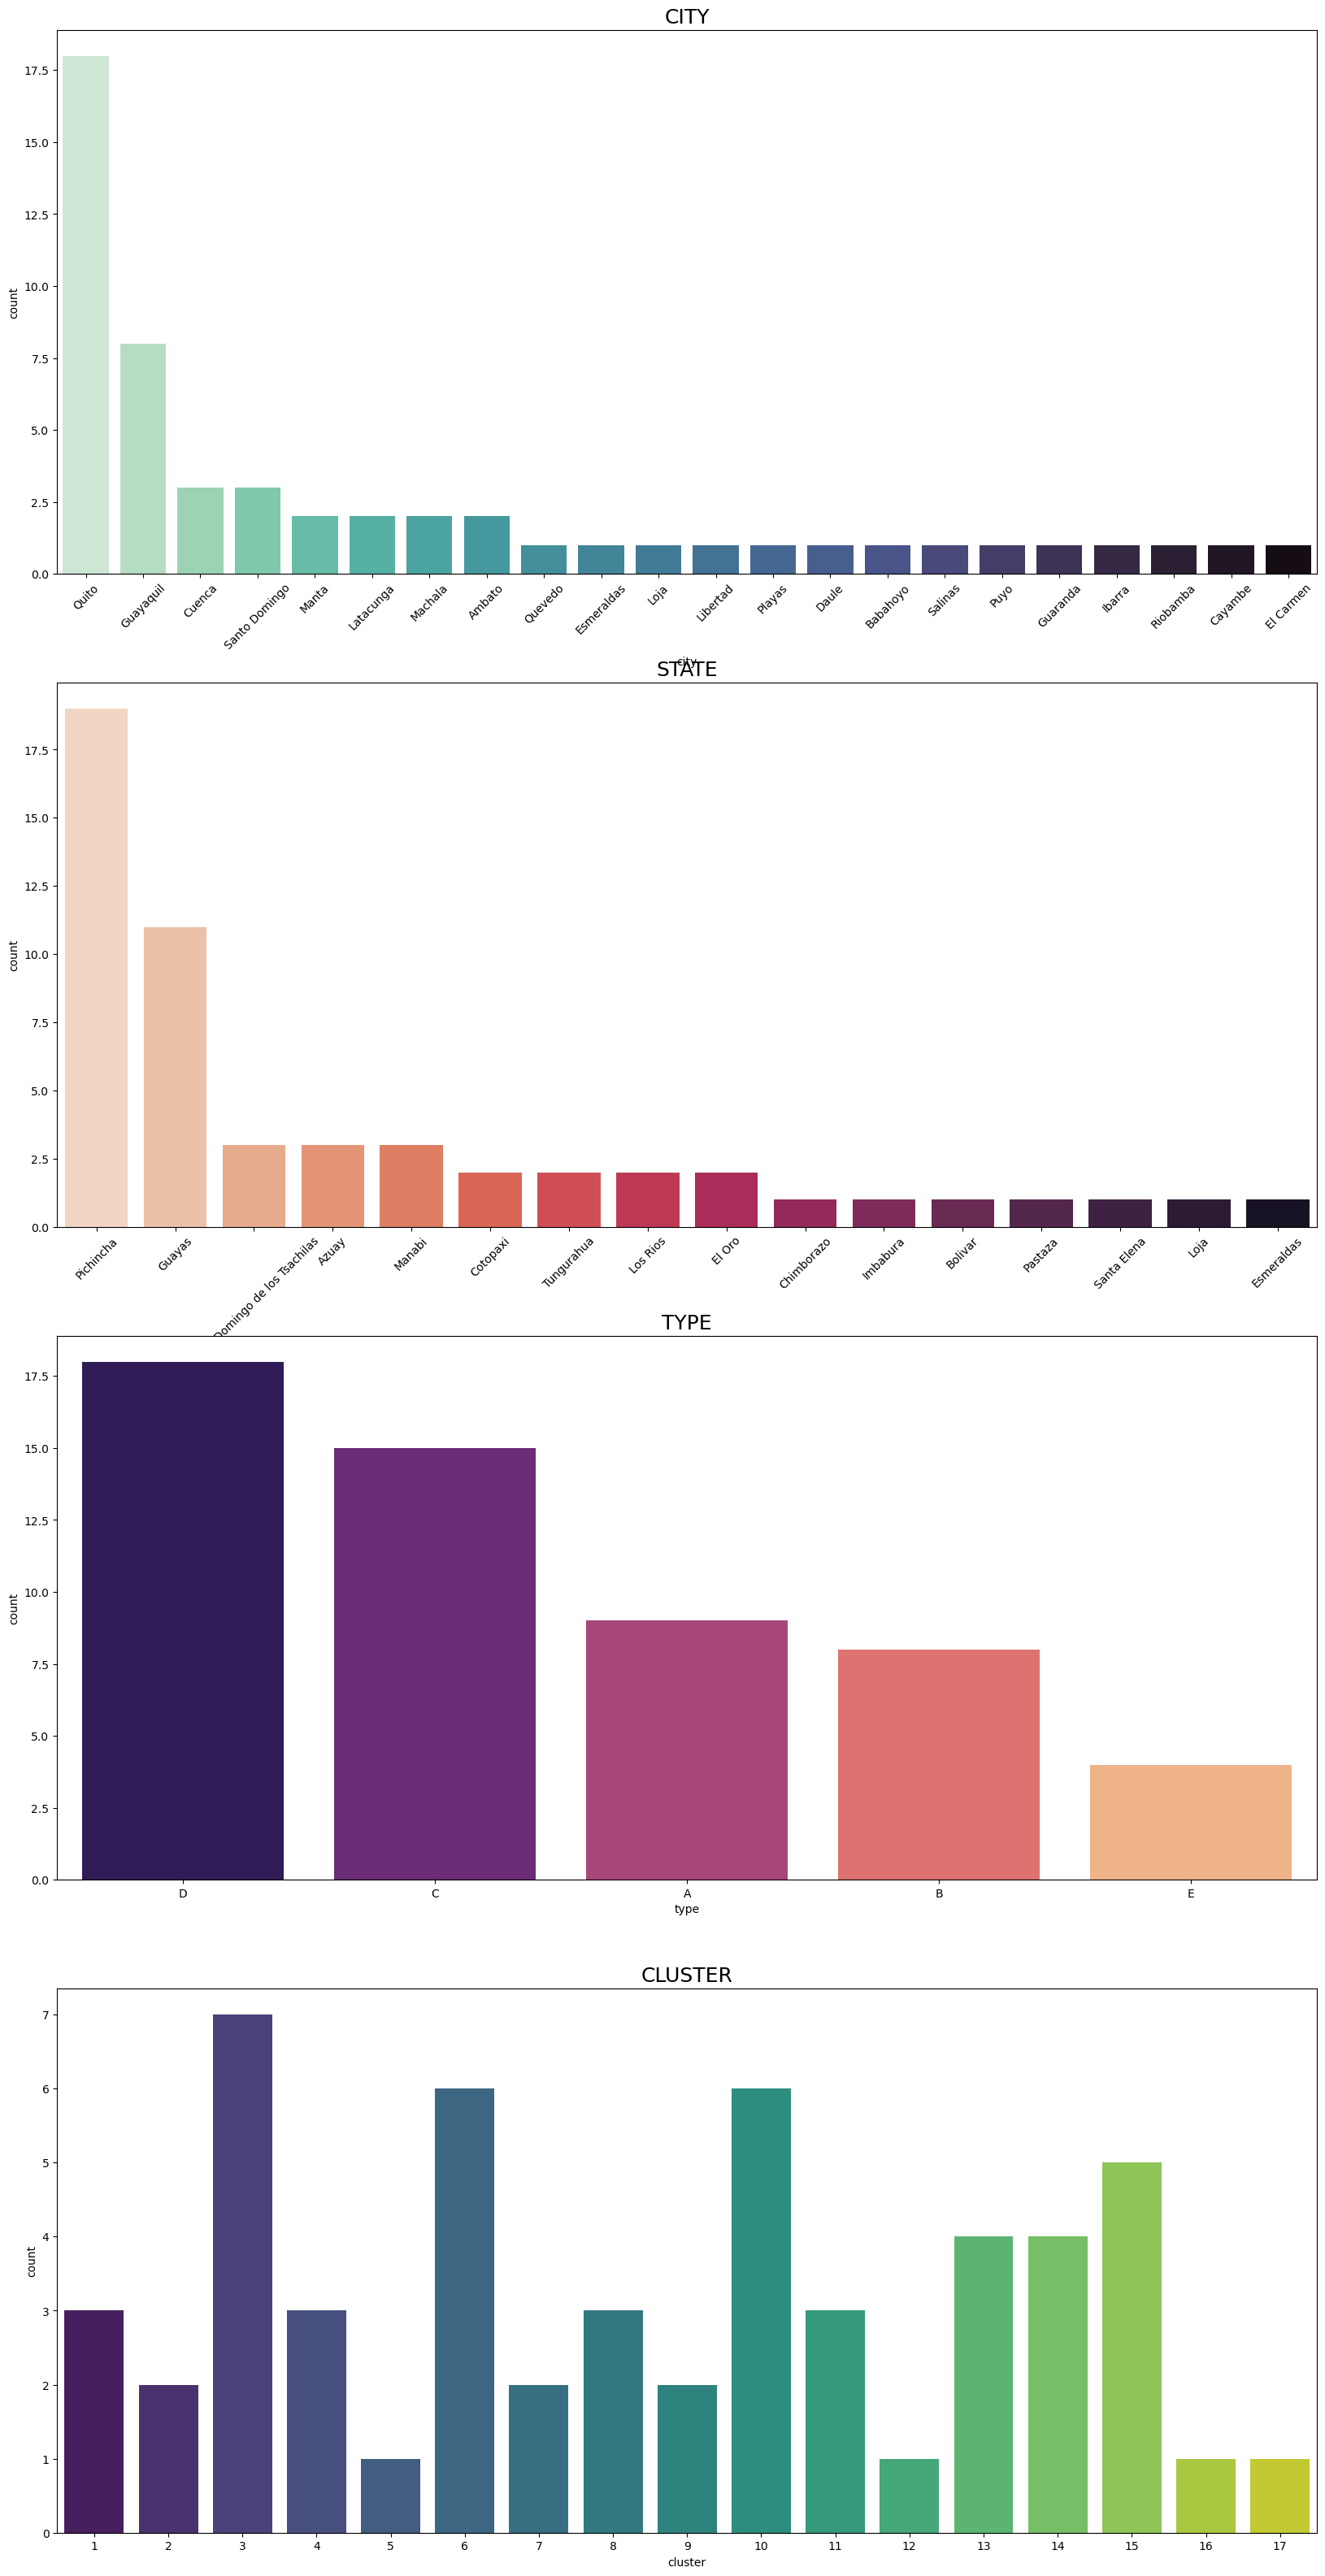

In [81]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20,40))
plot_stats(stores, "city", axes[0], "mako_r", 45)
plot_stats(stores, "state", axes[1], "rocket_r", 45)
plot_stats(stores, "type", axes[2], "magma", 0)
plot_stats(stores, "cluster", axes[3], "viridis", 0)
plt.show();

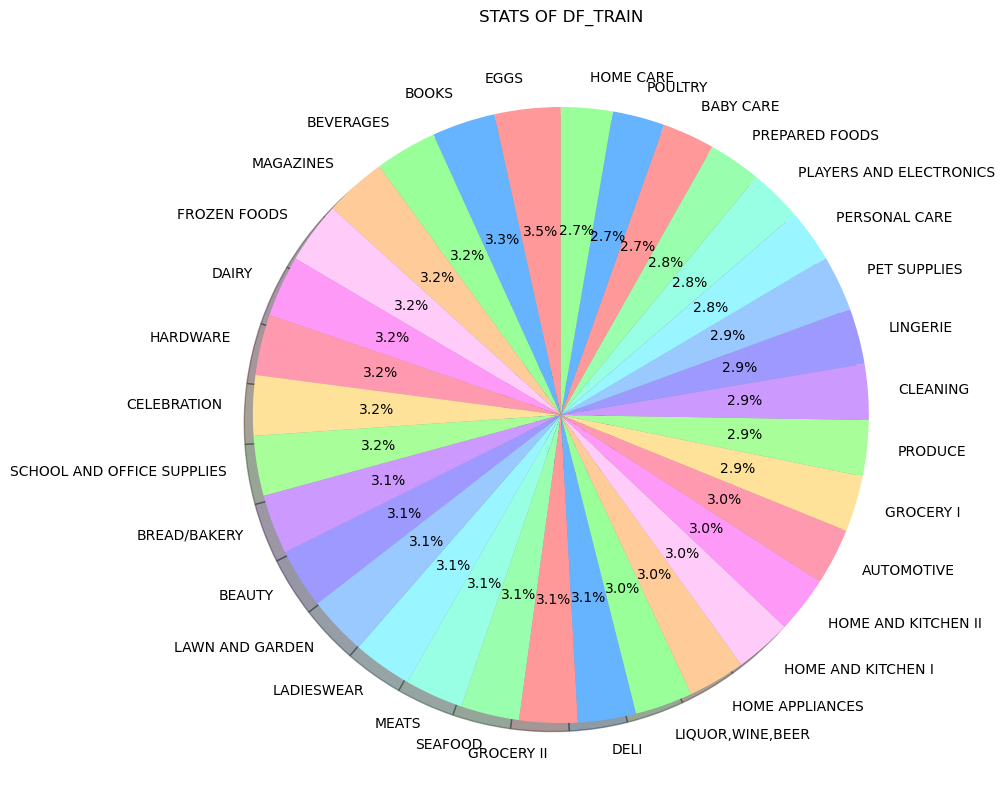

In [83]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
count_classes = df_train['family'].value_counts()
plt.title("Stats of df_train".upper())
colors = ['#ff9999','#66b3ff','#99ff99',
          '#ffcc99', '#ffccf9', '#ff99f8', 
          '#ff99af', '#ffe299', '#a8ff99',
          '#cc99ff', '#9e99ff', '#99c9ff',
          '#99f5ff', '#99ffe4', '#99ffaf']

plt.pie(count_classes, 
        labels = count_classes.index, 
        autopct='%1.1f%%',
        shadow=True, 
        startangle=90, 
        colors=colors)

plt.show()

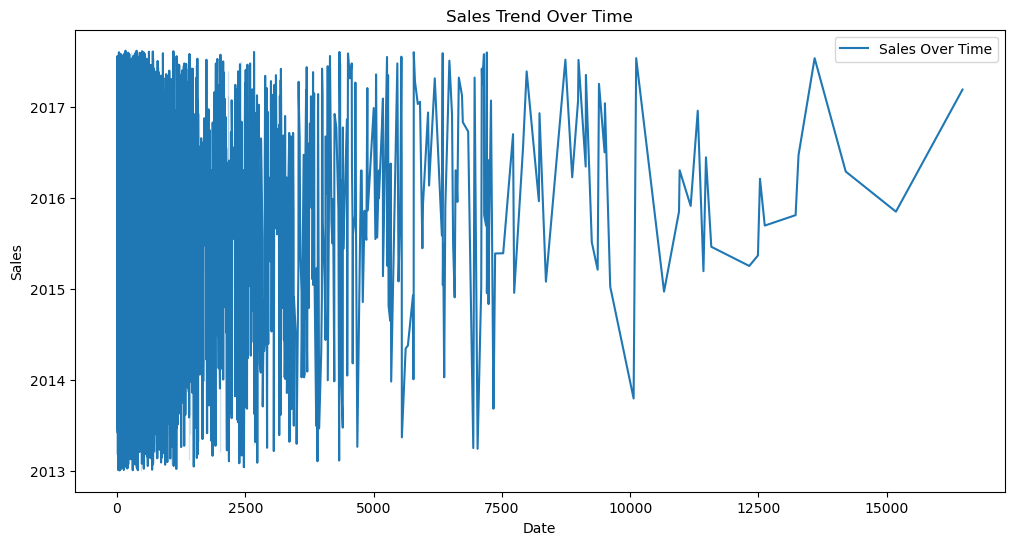

In [69]:
# Sales Trends over Time
import seaborn as sns
plt.figure(figsize=(12,6))
sns.lineplot(data=df_train, x='sales', y='date', label='Sales Over Time')
plt.title('Sales Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

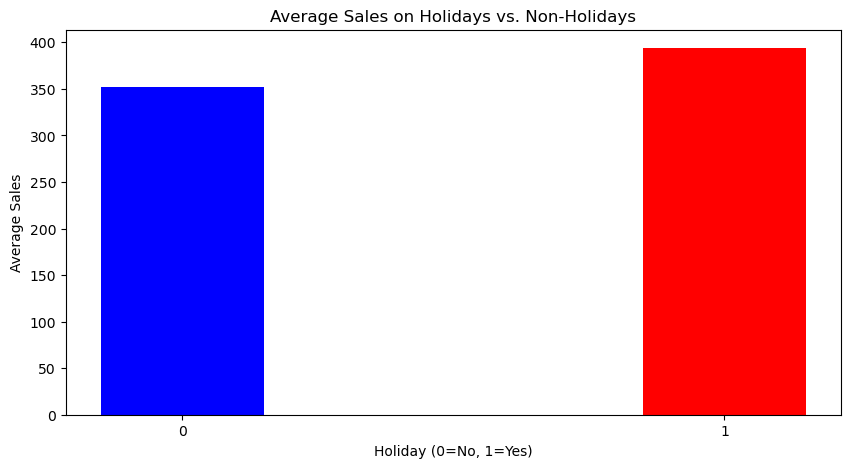

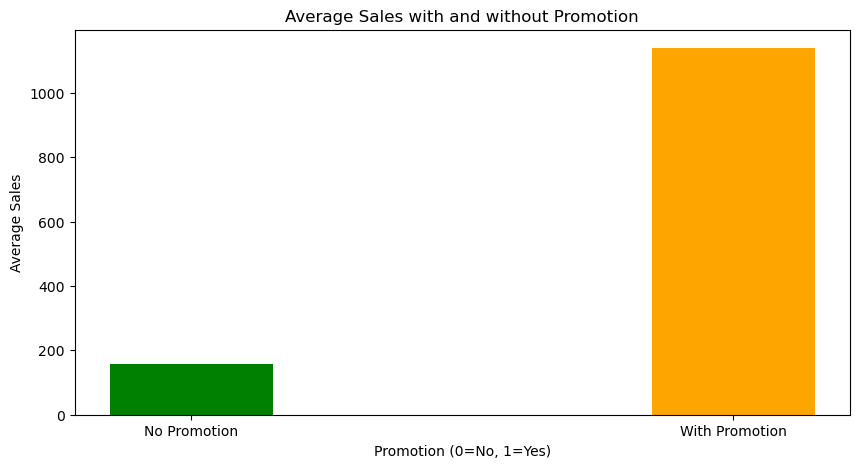

In [134]:
# Analyze Sales Before and After Holidays and Promotions
holiday_sales = df_train.groupby('is_holiday')['sales'].mean().reset_index()
df_train['promotion_flag'] = df_train['onpromotion'].apply(lambda x: 'No Promotion' if x == 0 else 'With Promotion')
promo_sales = df_train.groupby('promotion_flag')['sales'].mean().reset_index()

plt.figure(figsize=(10, 5))
plt.bar(holiday_sales['is_holiday'].astype(str), holiday_sales['sales'], color=['blue', 'red'], width=0.3)
plt.title('Average Sales on Holidays vs. Non-Holidays')
plt.xlabel('Holiday (0=No, 1=Yes)')
plt.ylabel('Average Sales')
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(promo_sales['promotion_flag'], promo_sales['sales'], color=['green', 'orange'], width=0.3)
plt.title('Average Sales with and without Promotion')
plt.xlabel('Promotion (0=No, 1=Yes)')
plt.ylabel('Average Sales')
plt.show()

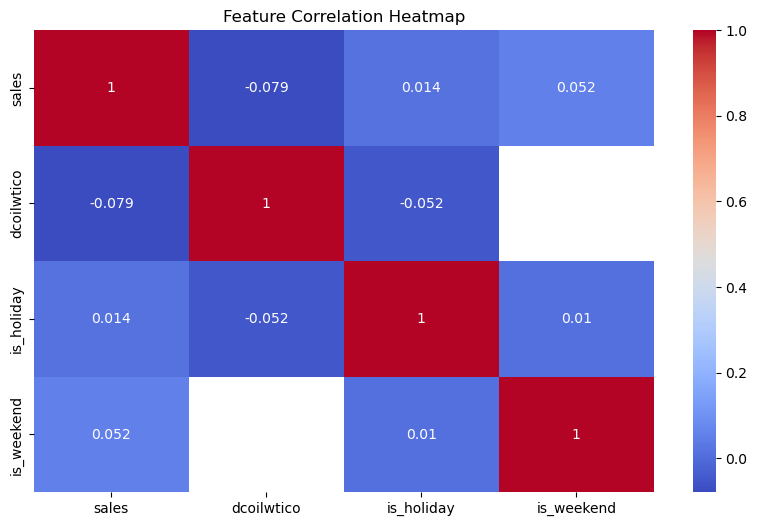

In [108]:
# Correlation Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df_train[['sales', 'dcoilwtico', 'is_holiday', 'is_weekend']].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

# Model Selection,Forecasting and Evaluation

In [158]:
df_train['promotion_flag'].value_counts()

promotion_flag
No Promotion      2428528
With Promotion     625820
Name: count, dtype: int64

In [154]:
df_train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,...,quarter,monthly_avg_sales,rolling_mean_30,is_payday,is_earthquake,lag_7,lag_30,rolling_mean_7,rolling_std_7,promotion_flag
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,1,3.141935,0.0,0,0,NaN,NaN,NaN,NaN,No Promotion
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,...,1,0.000000,0.0,0,0,NaN,NaN,NaN,NaN,No Promotion
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,...,1,2.129032,0.0,0,0,NaN,NaN,NaN,NaN,No Promotion
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,...,1,1615.354839,0.0,0,0,NaN,NaN,NaN,NaN,No Promotion
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,...,1,0.167742,0.0,0,0,NaN,NaN,NaN,NaN,No Promotion


In [38]:
from sklearn.model_selection import train_test_split

features=['day','month','year','day_of_week','is_holiday','is_weekend',
          'is_payday','is_earthquake','lag_7','lag_30','rolling_mean_7','rolling_std_7']
df_train=df_train.sample(10000)
x=df_train[features]
y=df_train['sales']

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)


In [40]:
# Baseline Model(Naive Forecasting)
y_pred_baseline=df_train.groupby(['store_nbr','family'])['sales'].shift(1)

# Assuming future sales = Previous sales

In [85]:
# ARIMA Model
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.arima.model import ARIMA

arima_model=ARIMA(y_train,order=(5,1,0))
arima_model_fit=arima_model.fit()
y_pred_arima=arima_model_fit.forecast(steps=len(y_test))

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [49]:
# RandomForest Model

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf_model=RandomForestRegressor(n_estimators=10,random_state=42)
rf_model.fit(x_train,y_train)
y_pred_rf=rf_model.predict(x_test)

rmse_rf=mean_squared_error(y_test,y_pred_rf,squared=False)
print(f'RandomForest RMSE: {rmse_rf}')

RandomForest RMSE: 272.28671426881675


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [51]:
#!pip install xgboost

In [53]:
# XGBoost Model

from xgboost import XGBRegressor

xgb_model=XGBRegressor(n_estimators=10,learning_rate=0.1,max_depth=5)
xgb_model.fit(x_train,y_train)
y_pred_xgb=xgb_model.predict(x_test)

rmse_xgb=mean_squared_error(y_test,y_pred_xgb,squared=False)
print(f'XGBoost RMSE: {rmse_xgb}')

XGBoost RMSE: 581.0377002139951


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [55]:
#!pip cache purge
#!pip install --no-cache-dir tensorflow


In [59]:
# LSTM Model

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

x_train_lstm=x_train.values.reshape((x_train.shape[0],x_train.shape[1],1))
x_test_lstm=x_test.values.reshape((x_test.shape[0],x_test.shape[1],1))

lstm_model= Sequential([
    LSTM(50,activation='relu',input_shape=(x_train_lstm.shape[1],1)),Dense(1)
])
lstm_model.compile(optimizer='adam',loss='mse')
lstm_model.fit(x_train_lstm,y_train,epochs=10,batch_size=64,validation_data=(x_test_lstm,y_test))
y_pred_lstm=lstm_model.predict(x_test_lstm)

rmse_lstm = mean_squared_error(y_test,y_pred_lstm,squared=False)
print(f'LSTM RMSE: {rmse_lstm}')

Epoch 1/10


C:\Users\Sharjeel\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: nan - val_loss: nan
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: nan - val_loss: nan
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: nan - val_loss: nan
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: nan - val_loss: nan
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: nan - val_loss: nan
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: nan - val_loss: nan
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: nan - val_loss: nan
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: nan - val_loss: nan
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: nan - val_loss: nan
Epoch 10/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: nan - val_loss: nan
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


ValueError: Input contains NaN.

### Model Evaluation

In [89]:
from sklearn.metrics import mean_absolute_percentage_error,r2_score

def eval(y_actual,y_pred,model):
    rmse=mean_squared_error(y_actual,y_pred,squared=False)
    mape=mean_absolute_percentage_error(y_actual,y_pred)
    #mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Avoid division by zero issues
    r2 = r2_score(y_actual,y_pred)
    
    print(f'{model} - RMSE: {rmse}, MAPE: {mape},R2: {r2}')
    #print(f"{model_name} - RMSE: {rmse:.2f}, MAPE: {mape:.2f}%, R²: {r2:.4f}")

eval(y_test,y_pred_arima,'ARIMA')
eval(y_test,y_pred_rf,'RandomForest')
eval(y_test,y_pred_xgb,'XGBoost')
#eval(y_test,y_pred_lstm,'LSTM')

ARIMA - RMSE: 1209.2983431238606, MAPE: 3.3713520598801594e+17,R2: -0.011242996118957294
RandomForest - RMSE: 272.28671426881675, MAPE: 4553373712118309.0,R2: 0.9487325739643089
XGBoost - RMSE: 581.0377002139951, MAPE: 1.7906118336372643e+17,R2: 0.7665481954038131


### Visualization

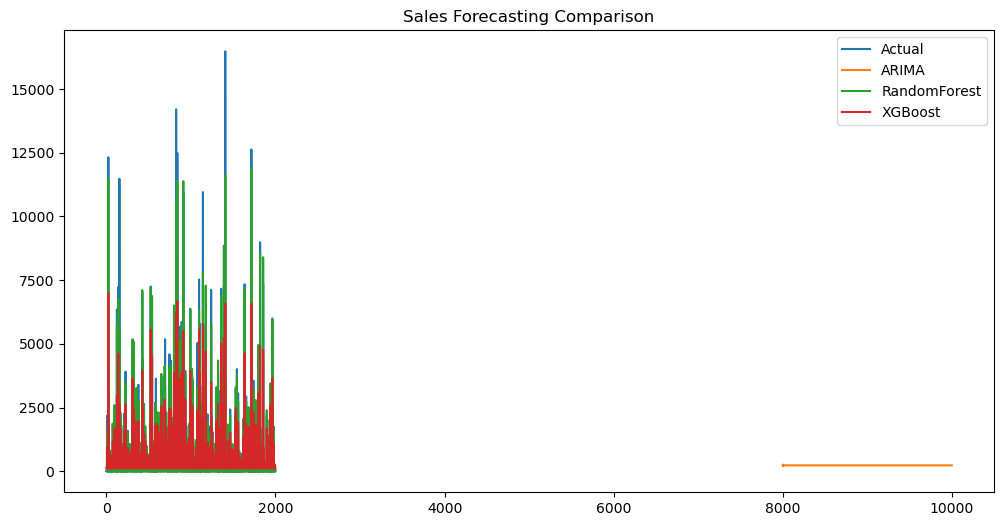

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
plt.plot(y_test.values,label='Actual')
plt.plot(y_pred_arima,label='ARIMA')
#plt.plot(y_pred_baseline,label='BaseLine')
plt.plot(y_pred_rf,label='RandomForest')
plt.plot(y_pred_xgb,label='XGBoost')
#plt.plot(y_pred_lstm,label='LSTM')
plt.legend()
plt.title('Sales Forecasting Comparison')
plt.show()

Impact of External Factors:

Holidays and oil prices significantly impact sales.

Government payday increases sales.

Business Strategy Recommendations:

Adjust promotions based on oil prices.

Stock more inventory before payday and holidays.

Holidays and Special Events
Impact:

Sales tend to spike before and during holidays as consumers stock up on essential and luxury items.

Certain holidays may lead to reduced sales due to store closures.

Holiday sales patterns are seasonal, meaning they follow a recurring trend each year.

Data Consideration:

Holiday Flags: Created binary indicators (0 or 1) to mark holidays.

Moving Averages: Used past sales trends around holidays to estimate future demand.

Event-Specific Analysis: Compared sales trends before and after major holidays.

Business Strategy Suggestion:
Retailers should optimize inventory for high-demand periods and launch special promotions before major holidays.

Oil Prices (Economic Influence)
Impact:

Ecuador's economy is closely tied to oil prices, affecting consumer spending power.

High oil prices may lead to increased transportation costs, raising product prices and reducing demand.

Low oil prices may encourage spending, boosting sales.

Data Consideration:

Rolling Averages: Analyzed trends in sales vs. oil price fluctuations.

Correlation Check: Identified whether oil price increases had a lagged effect on consumer spending.

Business Strategy Suggestion:
Companies should adjust pricing strategies during oil price fluctuations and optimize supply chain logistics.

Observations & Best Model:-
*Random Forest has the lowest RMSE (272.29) and highest R² score (0.9487), indicating it predicts closer to actual values.
However, its MAPE (4.55e+15) is extremely high, which suggests it struggles with percentage-based accuracy.
*ARIMA is the worst performer as it has the highest RMSE, highest MAPE, and a negative R², meaning it performs worse than a simple mean model.
*XGBoost is a solid alternative with better MAPE than Random Forest but has a higher RMSE and lower R² score.

Final Verdict:
Random Forest is the best model based on RMSE and R², but its extremely high MAPE is concerning.

